In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing import market_prepro

Now that we have Spencer's data importer lets make a driver that pulls in the data and training the model

SUDO CODE:

1. call data importer

2. restructure the dataset based on number of days desired [function written]

3. train model with training data

4. test model

5. return metrics

In [2]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
f = r'D:\Desktop\College Spring 2023\machineLearning\project\coding\data'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

print(X_train.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2010-07-21 to 2015-09-14
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1044 non-null   float64
 1   High              1044 non-null   float64
 2   Low               1044 non-null   float64
 3   Volume            1044 non-null   float64
 4   High-Low          1044 non-null   float64
 5   Close-Open        1044 non-null   float64
 6   Day_date          1044 non-null   int32  
 7   Month             1044 non-null   int32  
 8   Year              1044 non-null   int32  
 9   near_end_quarter  1044 non-null   int64  
 10  Day               1044 non-null   int64  
dtypes: float64(6), int32(3), int64(2)
memory usage: 85.6 KB
None


In [6]:
def structure_timeseries_features(df,offset,exclude):
    '''
    This takes a dataframe and creates new columns that contain the data from
    previous days so that time series forecasting can occur.

    INPUTS:
        df - dataframe: input data

        offset - int: the number of days to go back. This creates this many
                        new columns

        exclude - list str: list of columns to exclude from the time series 
                            expansion

    OUTPUTS:
        df_out - dataframe: dataframe with new columns
    '''

    df_out = pd.DataFrame() 

    for cc in df.columns.values:
        if (cc not in exclude):
            for ii in range(offset):
                col_name = (cc+"_m"+str(ii+1))

                df_out[col_name] = df[cc].shift(ii+1)


    df_out = df_out.iloc[offset:,:]

    return df_out

def structure_timeseries_targets(df,offset):
    '''
    companion function to remove the first few days of targets to make sure
    the sizes match between features and targets.

    INPUTS:
        df - dataframe: input data targets.

    OUTPUTS:
        df_out - dataframe: dataframe with rows removed

    '''
    df_out = df.iloc[offset:]

    return df_out

# df_ts = structure_timeseries_features(tt,2, ['Day_date','Month','Year'])


In [10]:
def modeldriver(mdl, n_days, f, st, sn):
    '''
    This function takes a model, imports the data, trains the model, and tests 
    the model

    INPUTS:
        mdl -  the model to test

        n_days- int: the number of days to go back to use as features

        f - str: filepath to the stock

        st - str: stock type

        sn - str: stock name
    OUTPUTS:
        NONE:
    '''

    exclude_col = ['Day_date','Month','Year']

    X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

    X_train = structure_timeseries_features(X_train,
                                            n_days, 
                                            exclude_col,
                                            )
    X_test = structure_timeseries_features(X_test,
                                           n_days, 
                                           exclude_col,
                                           )
    T_train =  structure_timeseries_targets(T_train,
                                            n_days,)
    T_test =  structure_timeseries_targets(T_test,
                                            n_days,)
    

    mdl.fit(X_train,T_train)

    y_train = mdl.predict(X_train)
    y_test = mdl.predict(X_test)

    score_train = mdl.score(X_train,T_train)
    score_test = mdl.score(X_test,T_test)

    print(score_train)
    print(score_test)

    return y_train, y_test, score_train, score_test


0.9925814298480372
0.9932517731355245


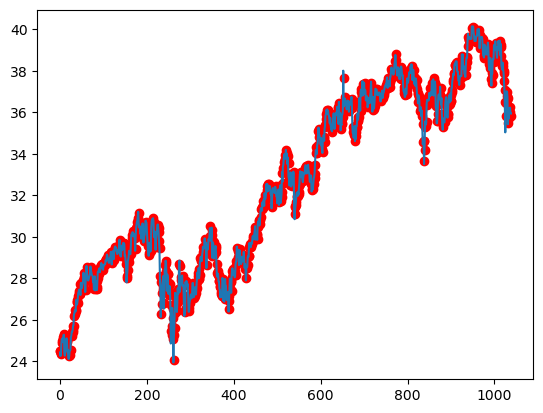

In [18]:
from sklearn.linear_model import Ridge

mdl_r = Ridge(alpha=0.01)

y_train, y_test, score_train, score_test = modeldriver(mdl_r, 5, f, st, sn)



# plt.scatter(y_train,T_train.iloc[5:])

plt.plot(range(0,len(T_train.iloc[5:])),T_train.iloc[5:])
plt.scatter(range(0,len(T_train.iloc[5:])),y_train,c='r')